## Configuration

In [1]:
from collections import Counter

import pandas as pd

FANMOD_path = "C:\\Users\\User\\source\\repos\\fanmod-cmd\\out\\build\\x64-release"
FANMOD_exe = "LocalFANMOD.exe"

raw_data_folder = './../../data'
raw_data_folder_dataset = '/melanoma_distance_100_XX'
output_dir = './../../fanmod_output'
cache_dir = './../../parse_cache'
results_dir = './../../results/melanoma_distance_100_XX'
motif_size = 5
iterations = 1000
force_run_fanmod = False
force_parse = False

In [2]:
cells_type = {
    0: 'B cell',
    1: 'CD4 APC',
    2: 'CD4 T cell',
    3: 'CD4 Treg',
    4: 'CD8 T cell',
    5: 'DCs',
    6: 'Germinal Center B cell',
    7: 'Hevs',
    8: 'MAC',
    9: 'Memory CD4 T Cell',
    10: 'NK cell',
    11: 'Neutrophil',
    12: 'Stroma',
    13: 'Tumor',
    14: 'Unidentified',
    15: 'Vessels'
}

Distant_metastases_class = {
    'NP': 'NP',
    'NN': 'NN',
    'PN': 'PN',
    'PP': 'PP',
}

class_to_color = {
    'NP': 'green',
    'NN': 'yellow',
    'PN': 'magenta',
    'PP': 'blue',
}

target_classes = ['NP', 'PN']
target_classes_str = 'NP_PN'

## Steps
1. Initiate CISM object
2. Load datasets
3. Initiate CISMTask

In [3]:
from cism.cism import CISM

In [4]:
cism = CISM(fanmod_exe=FANMOD_exe,
            fanmod_path=FANMOD_path,
            network_dataset_root_path=raw_data_folder,
            fanmod_output_root_path=output_dir,
            fanmod_cache_root_path=cache_dir,
            motif_size=motif_size,
            iterations=iterations)

# adding Melanoma dataset
cism.add_dataset(raw_data_folder_dataset, 'Disease', 'Melanoma', force_run_fanmod=force_run_fanmod, force_parse=force_parse, n_jobs=8, quantile_threshold=1)

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

In [5]:
from cism.cism import TissueStateDiscriminativeMotifs
from cism.cism import DiscriminativeFeatureKey

discriminator = TissueStateDiscriminativeMotifs(cism=cism,
                                                tissue_state_csv_path=raw_data_folder + raw_data_folder_dataset + '/patient_class.csv',
                                                tissue_state_to_string=Distant_metastases_class,
                                                common_cells_type=cells_type)

In [7]:
discriminator.get_patients_class(classes=None).groupby('patient_class').count()

,patient_class_id
patient_class,
NN,20
NP,18
PN,13
PP,17


## Figure 2
Context-dependent identification of spatial motifs can predict the state of human melanoma disease

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.


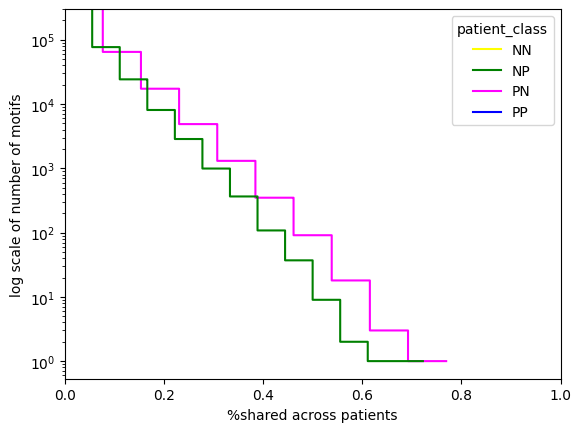

In [10]:
discover_result = discriminator.discover(extract_by=DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES, classes=target_classes)

discover_result.plot_number_of_motifs_versus_shared_percentage(class_to_color=class_to_color)

In [8]:
# export data to excel
discover_result.discriminative_motifs.drop(['Patient', 'FOV', 'Freq', 'Count', 'Mean_Freq', 'STD', 'z_score', 'p_value', 'Patient_uId'], axis=1).groupby('ID', observed=True).first().to_csv(results_dir +f'/{target_classes_str}_{motif_size}_number_of_motifs_versus_shared_percentage.csv')

### Performance Diagram
1. Pairwise Learning
2. 3 Nodes Motifs
3. 4 Nodes Motifs
4. 5 Nodes Motifs
5. Permutation tests (for threshold 0.46)
6. GNN Performance

Here we export the data for 1, 4, 5


#### Pairwise Learning

In [3]:
#read graphs
from pairwise.reader import GraphReader

full_graph_df = pd.DataFrame()
full_graph_df = GraphReader.get_graphs(full_graph_df=full_graph_df,
                                       raw_data_folder=raw_data_folder,
                                       raw_data_folder_type=raw_data_folder_dataset,
                                       disease='Melanoma',
                                       cells_type=cells_type)

In [4]:
from pairwise.pairwise_model import PairwiseAnalysis

pairwise_analysis = PairwiseAnalysis(
    tissue_state_csv_path=raw_data_folder + raw_data_folder_dataset + '/patient_class.csv',
    tissue_state_to_string=Distant_metastases_class)

In [10]:
cell_type_counts = pairwise_analysis.get_cell_type_count_from_classes(
                            full_graph_df=full_graph_df,
                            classes=['NN', 'NP','PN'],
                            cells_type=cells_type,
                            normalize=True)
cell_type_counts.to_csv(results_dir +'/NN_NP_PN_cell_type_frequency.csv')

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

In [25]:
group_a_general_pairwise = pairwise_analysis.get_pairwise_counter(
                                            full_graph_df=full_graph_df,
                                            patient_class='NP',
                                            cells_type=cells_type)
group_b_general_pairwise = pairwise_analysis.get_pairwise_counter(
                                            full_graph_df=full_graph_df,
                                            patient_class='PN',
                                            cells_type=cells_type)

In [27]:
group_a_general_pairwise = group_a_general_pairwise.drop(['Tumor'], axis=1)
group_a_general_pairwise = group_a_general_pairwise.drop(['Tumor'], axis=0)
group_b_general_pairwise = group_b_general_pairwise.drop(['Tumor'], axis=1)
group_b_general_pairwise = group_b_general_pairwise.drop(['Tumor'], axis=0)

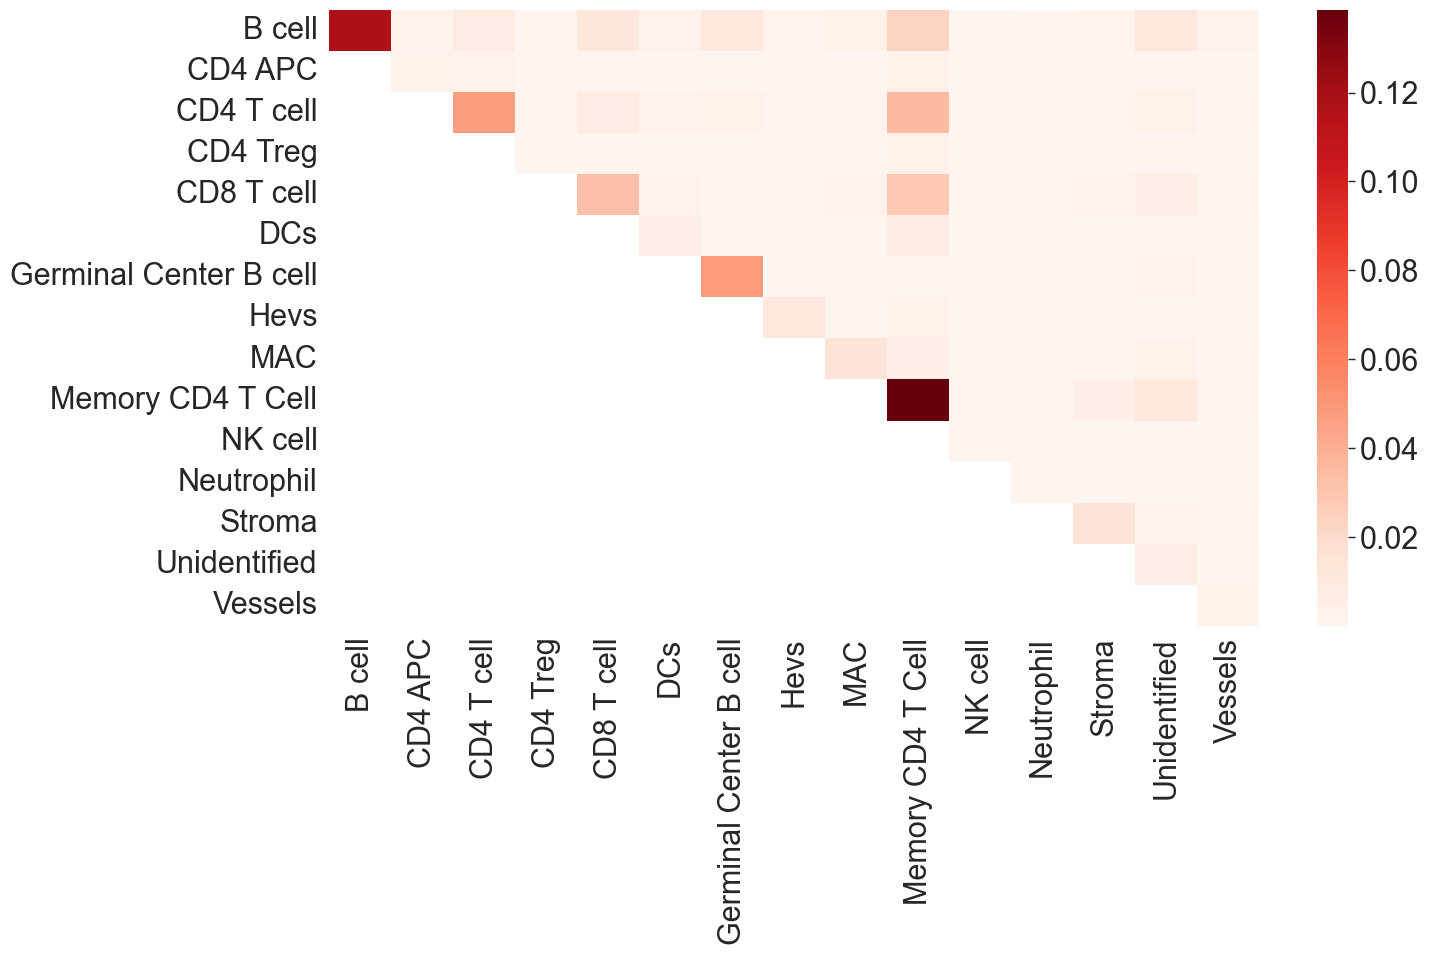

In [28]:
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np


plt.figure(figsize=(15,8))

sns.set(font_scale=2)
sns.set_style("white")
sns.set_context("paper", font_scale=2.5)

ax = sns.heatmap(group_a_general_pairwise, annot=False, mask=np.tril(np.ones_like(group_a_general_pairwise), k=-1), cmap='Reds', annot_kws={'size': 14}, fmt=".3f")

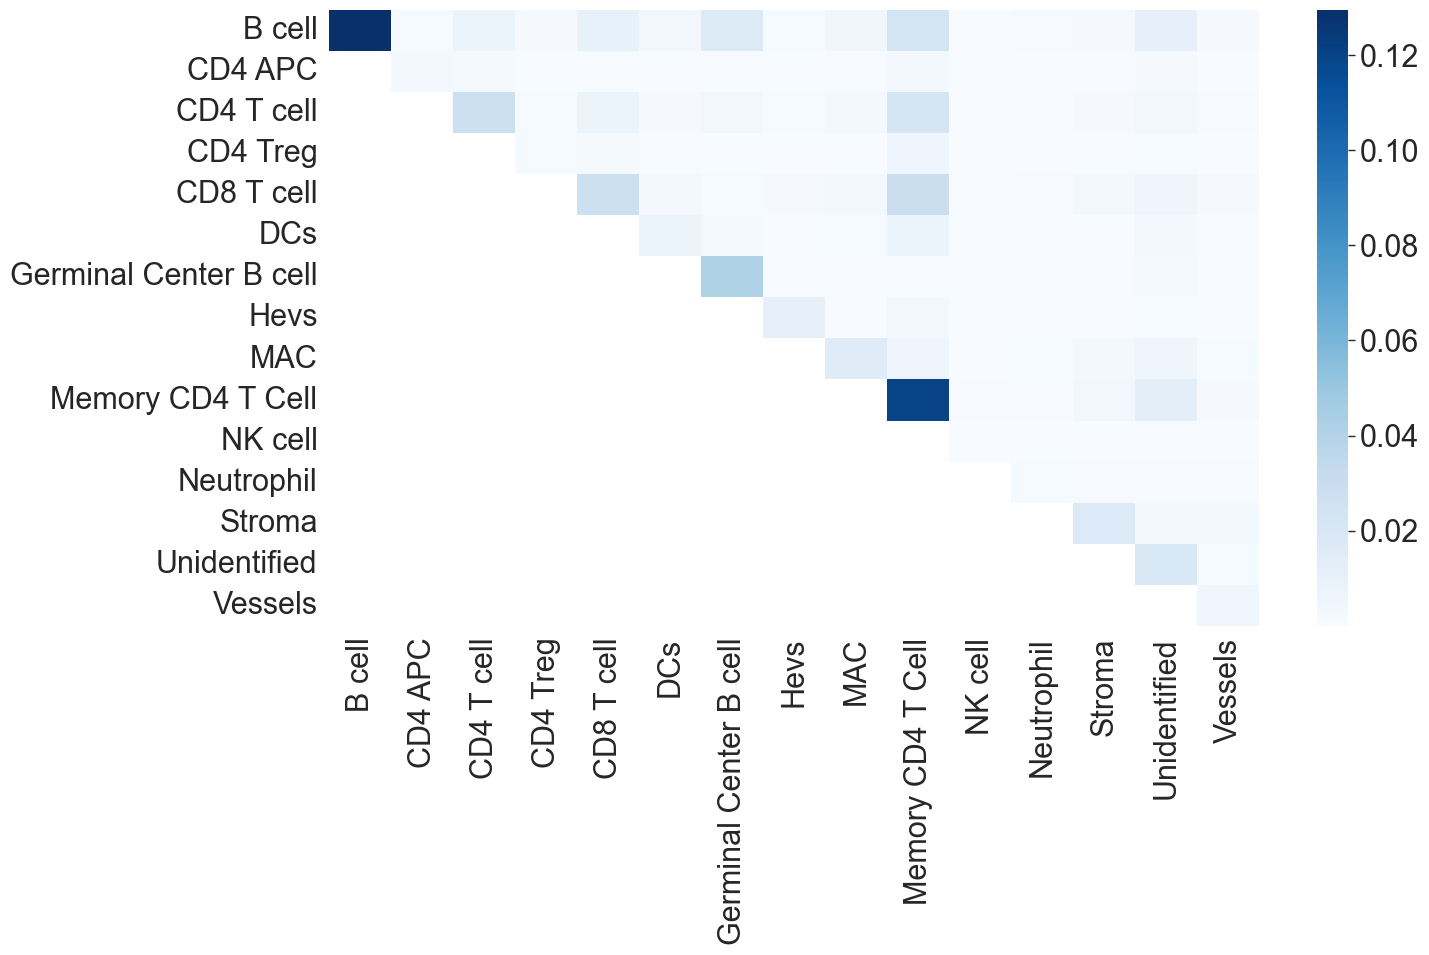

In [29]:
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np

plt.figure(figsize=(15,8))

sns.set(font_scale=2)
sns.set_style("white")
sns.set_context("paper", font_scale=2.5)

ax = sns.heatmap(group_b_general_pairwise, annot=False, mask=np.tril(np.ones_like(group_b_general_pairwise), k=-1), cmap='Blues', annot_kws={'size': 14}, fmt=".3f")

In [6]:
import numpy as np

roc_auc_scores = pairwise_analysis.analyze(full_graph_df=full_graph_df,
                                           cells_type=cells_type,
                                           labels=['PN', 'NP'],
                                           trials=10)

print(f'roc_auc_score - mean: {np.mean(roc_auc_scores)} std: {np.std(roc_auc_scores)}')

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

roc_auc_score - mean: 0.4784188034188034 std: 0.032524287524604185


#### Motifs 3 Nodes, 4 Nodes

In [3]:
from cism.cism import CISM

local_motif_size = 4

cism_4_nodes = CISM(fanmod_exe=FANMOD_exe,
                    fanmod_path=FANMOD_path,
                    network_dataset_root_path=raw_data_folder,
                    fanmod_output_root_path=output_dir,
                    fanmod_cache_root_path=cache_dir,
                    motif_size=local_motif_size,
                    iterations=iterations)

# adding Melanoma dataset
cism_4_nodes.add_dataset(raw_data_folder_dataset, 'Disease', 'Melanoma', force_run_fanmod=force_run_fanmod, force_parse=force_parse, n_jobs=8, quantile_threshold=1)

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

In [4]:
from cism.cism import TissueStateDiscriminativeMotifs

discriminator_4_nodes = TissueStateDiscriminativeMotifs(
                            cism=cism_4_nodes,
                            tissue_state_csv_path=raw_data_folder + raw_data_folder_dataset + '/patient_class.csv',
                            tissue_state_to_string=Distant_metastases_class,
                            common_cells_type=cells_type)

In [14]:
from cism.cism import TissueStateDiscriminativeMotifs
from cism.cism import DiscriminativeFeatureKey
from cism.benchmark import DiscriminatorBenchmark

discover_result = discriminator_4_nodes.discover(extract_by=DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES, classes=target_classes)

discover_result.discriminative_motifs.drop(['Patient', 'FOV', 'Freq', 'Count', 'Mean_Freq', 'STD', 'z_score', 'p_value', 'Patient_uId'], axis=1).groupby('ID', observed=True).first().to_csv(results_dir +f'/number_of_motifs_{target_classes_str}_{local_motif_size}_nodes_versus_shared_percentage.csv')

Number of Discriminative Motifs Permutation tests - 4 Nodes

In [16]:
perm_result_dict = dict()

In [17]:
from cism.cism import HardDiscriminativeFC

th = 0.5
feature_perm_conf = HardDiscriminativeFC(
                        extract_by=DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES,
                        use_cells_type_composition=False,
                        use_motifs=True,
                        shared_percentage=th,
                        max_class_features=100000,
                        labels=target_classes)

perm_result_dict[th] = [] if perm_result_dict.get(th) is None else perm_result_dict[th]
perm_result_dict[th].extend(discriminator_4_nodes.patient_class_permutation_test(
    feature_conf=feature_perm_conf,
    rand_patient_class=True,
    n_permutations=30,
    n_jobs=2))

  0%|          | 0/30 [00:00<?, ?it/s]

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


In [18]:
original_motifs_count = discriminator_4_nodes.patient_class_permutation_test(
    feature_conf=feature_perm_conf,
    rand_patient_class=False,
    n_permutations=1,
    n_jobs=1)
original_motifs_count

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

[97]

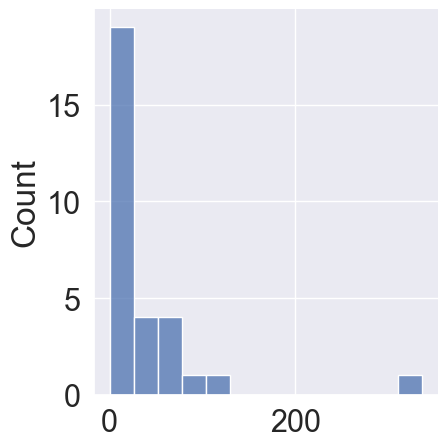

In [19]:
import seaborn as sns

sns.displot(perm_result_dict[th])

In [20]:
import numpy as np
np.where(np.array(perm_result_dict[th])>original_motifs_count)

(array([ 4, 22], dtype=int64),)

In [21]:
pd.DataFrame(perm_result_dict[th],columns=[f'th_{th}']).to_csv(results_dir +f'/number_of_motifs_100_{target_classes_str}_{local_motif_size}_permutation.csv')

Permutation of Motifs across Patients (pipeline)

In [ ]:
benchmark_results = None

for th in [0.54]:
    discriminator_benchmark = DiscriminatorBenchmark(
                                extract_by=DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES,
                                shared_percentage=th,
                                trials=list(range(0, 100)))

    # run permutation test
    benchmark_results = discriminator_benchmark.run(discriminator=discriminator_4_nodes,
                                                    labels=['NN', 'NP'],
                                                    rand_patient_class=False,
                                                    rand_motifs=True,
                                                    benchmark_results=benchmark_results,
                                                    n_jobs=2)

In [ ]:
benchmark_results.to_csv(results_dir +'/' + f'NN_NP_motif_pipeline_{local_motif_size}_benchmark.csv')

Permutation of Patients Classes (pipeline)

In [ ]:
benchmark_results = None

for th in [0.5]:
    discriminator_benchmark = DiscriminatorBenchmark(
                                extract_by=DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES,
                                shared_percentage=th,
                                trials=list(range(0, 100)))

    # run permutation test
    benchmark_results = discriminator_benchmark.run(discriminator=discriminator_4_nodes,
                                                    labels=target_classes,
                                                    rand_patient_class=True,
                                                    rand_motifs=False,
                                                    benchmark_results=benchmark_results,
                                                    max_class_features=30,
                                                    n_jobs=8)

In [23]:
benchmark_results.to_csv(results_dir +'/' + f'rand_patient_class_pipeline_{target_classes_str}_{local_motif_size}_benchmark.csv')

3 Nodes

In [16]:
local_motif_size = 3

cism_3_nodes = CISM(fanmod_exe=FANMOD_exe,
                    fanmod_path=FANMOD_path,
                    network_dataset_root_path=raw_data_folder,
                    fanmod_output_root_path=output_dir,
                    fanmod_cache_root_path=cache_dir,
                    motif_size=local_motif_size,
                    iterations=iterations)

# adding Melanoma dataset
cism_3_nodes.add_dataset(raw_data_folder_dataset, 'Disease', 'Melanoma', force_run_fanmod=force_run_fanmod, force_parse=force_parse, n_jobs=12, quantile_threshold=1)

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

In [18]:
benchmark_results = None

In [ ]:
from cism.cism import TissueStateDiscriminativeMotifs
from cism.cism import DiscriminativeFeatureKey
from cism.benchmark import DiscriminatorBenchmark

discriminator_3_nodes = TissueStateDiscriminativeMotifs(
                            cism=cism_3_nodes,
                            tissue_state_csv_path=raw_data_folder + raw_data_folder_dataset + '/patient_class.csv',
                            tissue_state_to_string=Distant_metastases_class,
                            common_cells_type=cells_type)

discover_result = discriminator_3_nodes.discover(extract_by=DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES, classes=['NP', 'PN'])

discover_result.discriminative_motifs.drop(['Patient', 'FOV', 'Freq', 'Count', 'Mean_Freq', 'STD', 'z_score', 'p_value', 'Patient_uId'], axis=1).groupby('ID', observed=True).first().to_csv(results_dir +f'/number_of_motifs_{local_motif_size}_nodes_versus_shared_percentage.csv')

for th in [0.2, 0.3, 0.4, 0.42, 0.44, 0.46, 0.48, 0.5, 0.6, 0.7, 0.72, 0.74, 0.76, 0.8]:
    discriminator_benchmark = DiscriminatorBenchmark(
                                extract_by=DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES,
                                shared_percentage=th,
                                trials=list(range(0, 1)))

    # run permutation test
    benchmark_results = discriminator_benchmark.run(discriminator=discriminator_3_nodes,
                                                    labels=['NP', 'PN'],
                                                    rand_patient_class=False,
                                                    benchmark_results=benchmark_results)

benchmark_results.to_csv(results_dir+'/' + f'pipeline_benchmark_{local_motif_size}_nodes.csv')

#### 3 Nodes AUC performance for patient classes permutation

In [22]:
benchmark_results = None

In [ ]:
from cism.benchmark import DiscriminatorBenchmark
import numpy as np

discriminator_benchmark = DiscriminatorBenchmark(
    extract_by=DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES,
    shared_percentage=0.4,
    trials=list(range(0, 30)))

# run permutation test
benchmark_results = discriminator_benchmark.run(discriminator=discriminator_3_nodes,
                                                labels=['NP', 'PN'],
                                                rand_patient_class=True,
                                                benchmark_results=benchmark_results)

discriminator_benchmark = DiscriminatorBenchmark(
    extract_by=DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES,
    shared_percentage=0.4,
    trials=list(range(0, 10)))

# run with real classes
benchmark_results = discriminator_benchmark.run(discriminator=discriminator_3_nodes,
                                                labels=['NP', 'PN'],
                                                benchmark_results=benchmark_results)

benchmark_results

In [26]:
benchmark_results.to_csv(results_dir +'/' + f'pipeline_NP_PN_{local_motif_size}_benchmark.csv')

#### Number of Discriminative Motifs Permutation tests

In [26]:
perm_result_dict = dict()

In [ ]:
from cism.cism import HardDiscriminativeFC

th = 0.45
feature_perm_conf = HardDiscriminativeFC(
                        extract_by=DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES,
                        use_cells_type_composition=False,
                        use_motifs=True,
                        shared_percentage=th,
                        max_class_features=100000,
                        labels=['NN', 'NP'])

perm_result_dict[th] = [] if perm_result_dict.get(th) is None else perm_result_dict[th]
perm_result_dict[th].extend(discriminator.patient_class_permutation_test(
    feature_conf=feature_perm_conf,
    rand_patient_class=True,
    n_permutations=100,
    n_jobs=3))

perm_result_dict

In [22]:
original_motifs_count = discriminator.patient_class_permutation_test(
    feature_conf=feature_perm_conf,
    rand_patient_class=False,
    n_permutations=1,
    n_jobs=1)
original_motifs_count

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

[59]

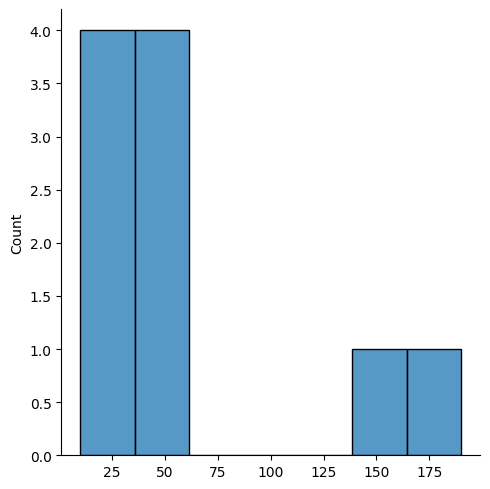

In [23]:
import seaborn as sns

sns.displot(perm_result_dict[th])

In [24]:
np.where(np.array(perm_result_dict[th])>original_motifs_count)

(array([1, 8], dtype=int64),)

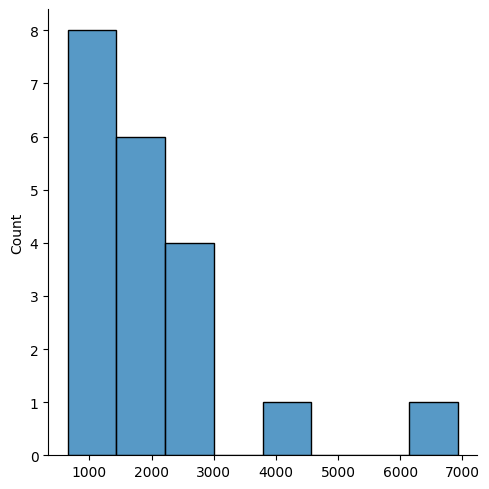

In [14]:
import seaborn as sns

sns.displot(perm_result_dict[th])

In [ ]:
2807

## Pipeline Permutation tests

In [6]:
benchmark_results = None

In [ ]:
from cism.benchmark import DiscriminatorBenchmark
import numpy as np

discriminator_benchmark = DiscriminatorBenchmark(
    extract_by=DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES,
    shared_percentage=0.46,
    trials=list(range(0, 30)))

# run permutation test
benchmark_results = discriminator_benchmark.run(discriminator=discriminator,
                                                labels=['NN', 'NP'],
                                                rand_patient_class=True,
                                                benchmark_results=benchmark_results)

discriminator_benchmark = DiscriminatorBenchmark(
    extract_by=DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES,
    shared_percentage=0.46,
    trials=list(range(0, 10)))

# run with real classes
benchmark_results = discriminator_benchmark.run(discriminator=discriminator,
                                                labels=['NN', 'NP'],
                                                benchmark_results=benchmark_results)

benchmark_results

In [8]:
benchmark_results.to_csv(results_dir +'/' + 'NN_NP_pipeline_benchmark.csv')

In [10]:
benchmark_results

## Pipeline randomize the motifs across the dataset

In [6]:
benchmark_results = None

In [ ]:
from cism.benchmark import DiscriminatorBenchmark

# run permutation test
discriminator_benchmark = DiscriminatorBenchmark(
                          extract_by=DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES,
                          shared_percentage=0.46,
                          trials=list(range(0, 100)))

# run permutation test
benchmark_results = discriminator_benchmark.run(discriminator=discriminator,
                                                labels=['NN', 'NP'],
                                                rand_patient_class=False,
                                                rand_motifs=True,
                                                benchmark_results=benchmark_results,
                                                n_jobs=1)

benchmark_results

In [ ]:
benchmark_results.to_csv(results_dir +'/' + 'NN_NP_motif_pipeline_benchmark.csv')

## 4 Nodes
## Within-motif spatial organization contributes to disease state prediction

In [8]:
shared_percentage_th = 0.54

In [12]:
from cism.cism import DiscriminativeFeatureKey, HardDiscriminativeFC

featureConf = HardDiscriminativeFC(extract_by=DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES,
                                   use_cells_type_composition=False,
                                   use_motifs=True,
                                   shared_percentage=shared_percentage_th,
                                   max_class_features=10,
                                   labels=['NN', 'NP'])

motif_space_features = discriminator_4_nodes.get_features(feature_conf=featureConf,
                                                          exclude_patients=[],
                                                          n_jobs=1)

  0%|          | 0/38 [00:00<?, ?it/s]

FixedFormatter should only be used together with FixedLocator


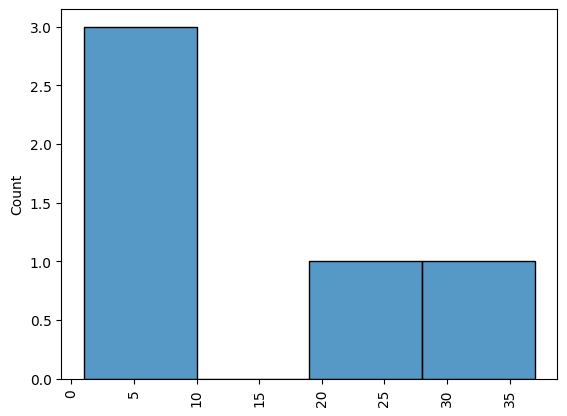

In [15]:
from matplotlib import pyplot as plt
import seaborn as sns

counter_across_patients = Counter()
for idx, row in motif_space_features.iterrows():
    counter_across_patients.update(row['features'])

g = sns.histplot(counter_across_patients)
g.set_xticklabels(g.get_xticklabels(), rotation=90)
plt.show()

In [16]:
optimal_result = discriminator_4_nodes.analyze_motifs(feature_conf=featureConf,
                                                      exclude_patients=[],
                                                      n_jobs=1)

  0%|          | 0/38 [00:00<?, ?it/s]

In [17]:
optimal_result.get_roc_auc_score()

0.8611111111111112

In [19]:
all_motif_features = []
for idx, row in motif_space_features.iterrows():
    all_motif_features += row['features']
all_motif_features = list(set(all_motif_features))

motif_to_cells_identity_hash = {}
for motif_id in all_motif_features:
    motif_to_cells_identity_hash[motif_id] = discriminator_4_nodes.cism.motifs_dataset[discriminator_4_nodes.cism.motifs_dataset.ID == motif_id].colors_vec_hash.iloc[0]

cell_identity_to_motif_hash = {}
for k, v in motif_to_cells_identity_hash.items():
    cell_identity_to_motif_hash[v] = cell_identity_to_motif_hash.get(v, []) + [k]

print(f"number of motifs: {len(motif_to_cells_identity_hash)}, "
      f"number of hashes: {len(cell_identity_to_motif_hash)}")

motif_to_cells_identity_hash

number of motifs: 5, number of hashes: 5


{4071751116: -3224596876564360443,
 11561745772: 3341299229835211946,
 2454267148: -2785496978450312591,
 15341317580: 6191483428857422447,
 4880694732: 6501729852448164872}

In [40]:
group_a_motifs = []
group_b_motifs = []

relevant_patients = discriminator_4_nodes.get_patients_class(['NN', 'NP'])
for motif_id in all_motif_features:
    patients_ids = discriminator_4_nodes.cism.motifs_dataset[
        (discriminator_4_nodes.cism.motifs_dataset.ID == motif_id) &
        (discriminator_4_nodes.cism.motifs_dataset['Patient_uId'].isin(relevant_patients.index))]['Patient_uId'].unique()
    groups_ids = map(lambda x: relevant_patients.loc[x]['patient_class'], patients_ids)
    counter = Counter(groups_ids)
    if max(counter, key=counter.get) == 'NN':
        group_a_motifs.append(motif_id)
    else:
        group_b_motifs.append(motif_id)

In [7]:
from cism import helpers
import networkx as nx
import numpy as np

def create_weight_matrix_from_motifs(discriminator,
                                     cells_type: dict,
                                     cell_identity_to_motif_hash: dict,
                                     motifs_ids: list) -> pd.DataFrame:
    pairwise_cell_types_count_matrix = pd.DataFrame(index=cells_type.values(),
                                                    columns=cells_type.values(),
                                                    dtype=float).fillna(0)

    for hash_id in list(cell_identity_to_motif_hash.keys()):
        motifs = cell_identity_to_motif_hash[hash_id]
        for motif_id in motifs:
            if motif_id not in motifs_ids:
                continue
            print(f'motif_id: {motif_id}, hash_id: {hash_id}')
            target_motif = discriminator.cism.motifs_dataset[discriminator.cism.motifs_dataset.ID == motif_id].iloc[0].motif
            target_motif = helpers.string_base64_pickle(target_motif)
            for edge in nx.Graph(target_motif).edges():
                left_node = target_motif.nodes[edge[0]]['type']
                right_node = target_motif.nodes[edge[1]]['type']
                pairwise_cell_types_count_matrix.loc[cells_type[int(left_node)], cells_type[int(right_node)]] += 1

    return pairwise_cell_types_count_matrix/np.matrix(pairwise_cell_types_count_matrix).sum()

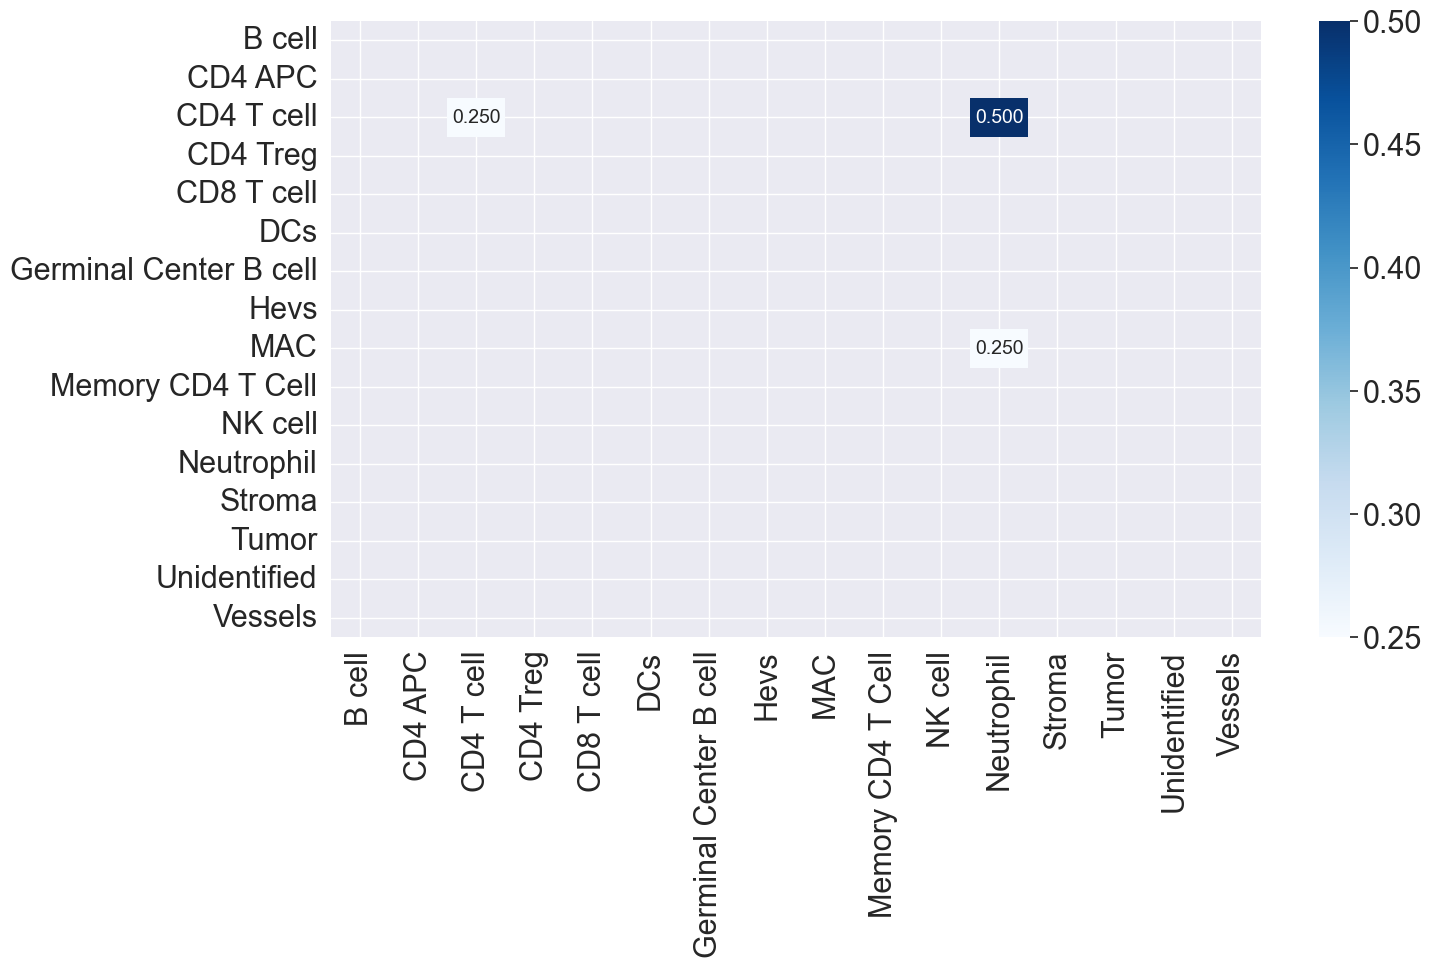

In [44]:
import seaborn as sns
from matplotlib import pyplot as plt

plt.figure(figsize=(15,8))

sns.set(font_scale=2)

df = create_weight_matrix_from_motifs(discriminator=discriminator_4_nodes,
                                      cells_type=cells_type,
                                      cell_identity_to_motif_hash=cell_identity_to_motif_hash,
                                      motifs_ids=group_a_motifs)

ax = sns.heatmap(df, annot=True, mask=df==0, cmap='Blues', annot_kws={'size': 14}, fmt=".3f")

motif_id: 2454267148, hash_id: -2785496978450312591


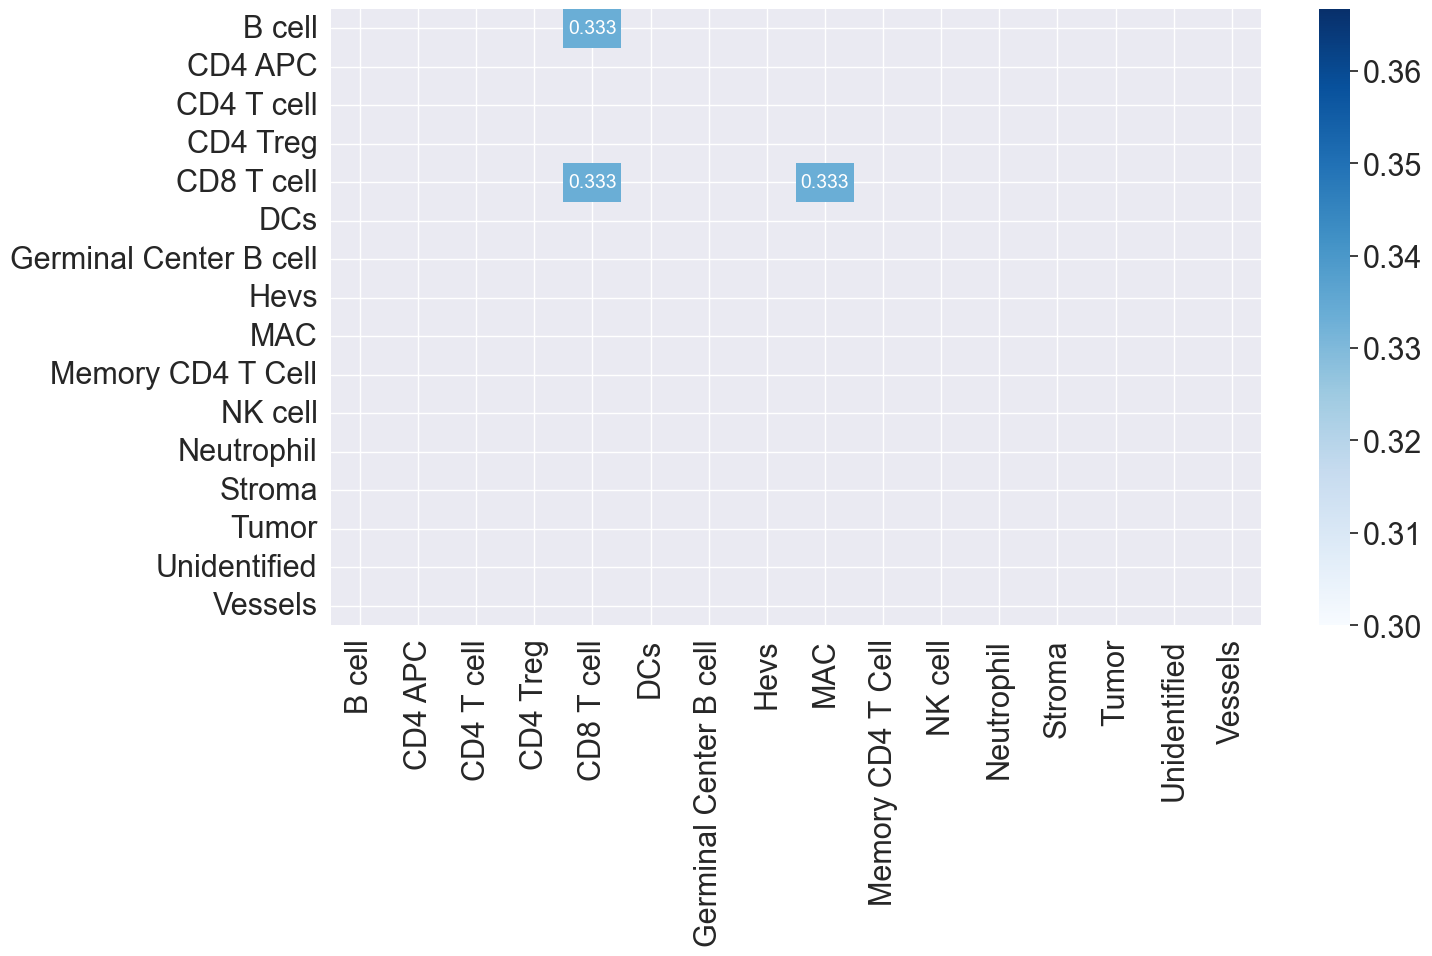

In [55]:
import seaborn as sns
from matplotlib import pyplot as plt

plt.figure(figsize=(15,8))

sns.set(font_scale=2)

df = create_weight_matrix_from_motifs(discriminator=discriminator_4_nodes,
                                      cells_type=cells_type,
                                      cell_identity_to_motif_hash=cell_identity_to_motif_hash,
                                      motifs_ids=group_b_motifs[1:2])

ax = sns.heatmap(df, annot=True, mask=df==0, cmap='Blues', annot_kws={'size': 14}, fmt=".3f")

In [57]:
from typing import Union

def switch_ci(motif_space_features: pd.DataFrame,
              target_motif_ids: list,
              motif_to_cells_identity_hash: dict) -> (dict, dict):
    motifs_features_dict = dict()
    ci_features_dict = dict()

    for idx, row in motif_space_features.iterrows():
        patient_unique_id = row['test_patient_id']
        motif_ids = row['features']
        # transform to cell identity composition
        ci_features = []
        motifs_features = []
        for motif_id in motif_ids:
            if motif_id in target_motif_ids:
                motifs_features.append(motif_id)
                continue

            ci_features.append(motif_to_cells_identity_hash[motif_id])

        ci_features = list(set(ci_features))
        motifs_features_dict[patient_unique_id] = motifs_features
        ci_features_dict[patient_unique_id] = ci_features

    return motifs_features_dict, ci_features_dict

import numpy as np

switch_all_roc_auc_scores = []
for trial in range(10):
    motifs_patient_map, cell_type_composition_patient_map = \
        switch_ci(motif_space_features=motif_space_features,
                  target_motif_ids=[],
                  motif_to_cells_identity_hash=motif_to_cells_identity_hash)

    featureConf = HardDiscriminativeFC(
        extract_by=DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES,
        use_cells_type_composition=False,
        use_motifs=True,
        shared_percentage=shared_percentage_th,
        max_class_features=10,
        labels=['NN', 'NP'],
        cell_type_composition_patient_map=cell_type_composition_patient_map,
        motifs_patient_map=motifs_patient_map)

    switch_all_result = discriminator_4_nodes.analyze_motifs(feature_conf=featureConf,
                                                             exclude_patients=[],
                                                             n_jobs=1,
                                                             random_state=np.random.RandomState(trial))

    switch_all_roc_auc_scores.append(switch_all_result.get_roc_auc_score())
    print(switch_all_result.get_roc_auc_score())

np.mean(switch_all_roc_auc_scores)

  0%|          | 0/38 [00:00<?, ?it/s]

0.45555555555555555


  0%|          | 0/38 [00:00<?, ?it/s]

0.4541666666666666


  0%|          | 0/38 [00:00<?, ?it/s]

0.4583333333333333


  0%|          | 0/38 [00:00<?, ?it/s]

0.4736111111111111


  0%|          | 0/38 [00:00<?, ?it/s]

0.45555555555555555


  0%|          | 0/38 [00:00<?, ?it/s]

0.46249999999999997


  0%|          | 0/38 [00:00<?, ?it/s]

0.47500000000000003


  0%|          | 0/38 [00:00<?, ?it/s]

0.4763888888888889


  0%|          | 0/38 [00:00<?, ?it/s]

0.49444444444444446


  0%|          | 0/38 [00:00<?, ?it/s]

0.5055555555555555


0.47111111111111115

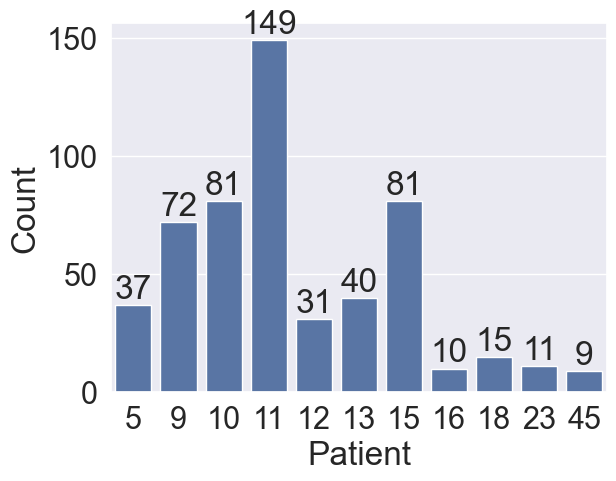

In [80]:
ax = sns.barplot(data=discriminator_4_nodes.cism.motifs_dataset[
        (discriminator_4_nodes.cism.motifs_dataset.ID.isin(group_b_motifs[1:2])) &
        (discriminator_4_nodes.cism.motifs_dataset['Patient_uId'].isin(relevant_patients.index))].groupby('Patient')['Count'].sum().reset_index(),
             x='Patient', y='Count')

for i in ax.containers:
    ax.bar_label(i,)

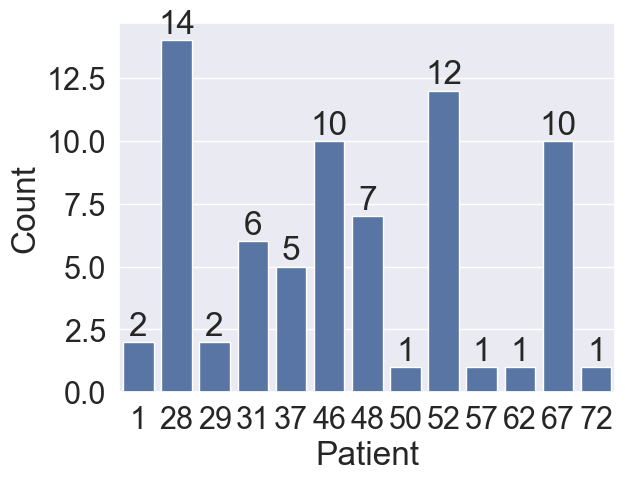

In [82]:
ax = sns.barplot(data=discriminator_4_nodes.cism.motifs_dataset[
        (discriminator_4_nodes.cism.motifs_dataset.ID.isin(group_a_motifs)) &
        (discriminator_4_nodes.cism.motifs_dataset['Patient_uId'].isin(relevant_patients.index))].groupby('Patient')['Count'].sum().reset_index(),
             x='Patient', y='Count')

for i in ax.containers:
    ax.bar_label(i,)

In [84]:
import numpy as np
ratio_gain_results = pd.DataFrame(columns=['hash'])

for motif_id in all_motif_features:
    hash = motif_to_cells_identity_hash[motif_id]
    # get the hash group
    motif_ids = cell_identity_to_motif_hash[hash]

    if any(ratio_gain_results.hash.isin([hash])):
        continue

    motifs_patient_map, cell_type_composition_patient_map = \
            switch_ci(motif_space_features=motif_space_features,
                      target_motif_ids=motif_ids,
                      motif_to_cells_identity_hash=motif_to_cells_identity_hash)

    roc_auc_scores = []
    for trial in [0]:
        featureConf = HardDiscriminativeFC(
            extract_by=DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES,
            use_cells_type_composition=False,
            use_motifs=True,
            shared_percentage=shared_percentage_th,
            max_class_features=10,
            labels=['NN', 'NP'],
            cell_type_composition_patient_map=cell_type_composition_patient_map,
            motifs_patient_map=motifs_patient_map)

        analyze_motifs_result = discriminator_4_nodes.analyze_motifs(feature_conf=featureConf,
                                                             exclude_patients=[],
                                                             n_jobs=1,
                                                             random_state=0)

        roc_auc_score = analyze_motifs_result.get_roc_auc_score()
        roc_auc_scores.append(roc_auc_score)

    print(f'hash: {hash}, '
          f'roc_auc_score: {np.mean(roc_auc_scores)}, '
          f'roc_auc_ratio: {optimal_result.get_roc_auc_score()/np.mean(roc_auc_scores)}, '
          f"avg features: {analyze_motifs_result.results['cFeatures'].mean()}, "
          f"std features: {analyze_motifs_result.results['cFeatures'].std()}, "
          f"number of mapped features: {len(motif_ids)}")

    ratio_gain_results = pd.concat([ratio_gain_results,
                                    pd.DataFrame([{'hash': hash,
                                                   'roc_auc_score': np.mean(roc_auc_scores),
                                                   'roc_auc_score_std': np.std(roc_auc_scores),
                                                   'roc_auc_scores': roc_auc_scores,
                                                   'roc_auc_ratio': optimal_result.get_roc_auc_score()/np.mean(roc_auc_scores),
                                                   'avg_features': analyze_motifs_result.results['cFeatures'].mean(),
                                                   'std_features': analyze_motifs_result.results['cFeatures'].std(),
                                                   'mapped_features': len(motif_ids),
                                                   'analyze_result': analyze_motifs_result}])], ignore_index=True)
ratio_gain_results

  0%|          | 0/38 [00:00<?, ?it/s]

hash: -3224596876564360443, roc_auc_score: 0.6888888888888889, roc_auc_ratio: 1.25, avg features: 1.763157894736842, std features: 0.5419788829194208, number of mapped features: 1


  0%|          | 0/38 [00:00<?, ?it/s]

hash: 3341299229835211946, roc_auc_score: 0.4458333333333333, roc_auc_ratio: 1.9314641744548289, avg features: 1.763157894736842, std features: 0.5419788829194208, number of mapped features: 1


  0%|          | 0/38 [00:00<?, ?it/s]

hash: -2785496978450312591, roc_auc_score: 0.4388888888888889, roc_auc_ratio: 1.9620253164556964, avg features: 1.763157894736842, std features: 0.5419788829194208, number of mapped features: 1


  0%|          | 0/38 [00:00<?, ?it/s]

hash: 6191483428857422447, roc_auc_score: 0.7805555555555556, roc_auc_ratio: 1.103202846975089, avg features: 1.763157894736842, std features: 0.5419788829194208, number of mapped features: 1


  0%|          | 0/38 [00:00<?, ?it/s]

hash: 6501729852448164872, roc_auc_score: 0.45, roc_auc_ratio: 1.9135802469135803, avg features: 1.763157894736842, std features: 0.5419788829194208, number of mapped features: 1


,hash,roc_auc_score,roc_auc_score_std,roc_auc_scores,roc_auc_ratio,avg_features,std_features,mapped_features,analyze_result
0,-3224596876564360443,0.688889,0.0,[0.6888888888888889],1.250000,1.763158,0.541979,1.0,<cism.cism.AnalyzeMotifsResult object at 0x000...
1,3341299229835211946,0.445833,0.0,[0.4458333333333333],1.931464,1.763158,0.541979,1.0,<cism.cism.AnalyzeMotifsResult object at 0x000...
2,-2785496978450312591,0.438889,0.0,[0.4388888888888889],1.962025,1.763158,0.541979,1.0,<cism.cism.AnalyzeMotifsResult object at 0x000...
3,6191483428857422447,0.780556,0.0,[0.7805555555555556],1.103203,1.763158,0.541979,1.0,<cism.cism.AnalyzeMotifsResult object at 0x000...
4,6501729852448164872,0.450000,0.0,[0.45],1.913580,1.763158,0.541979,1.0,<cism.cism.AnalyzeMotifsResult object at 0x000...


In [85]:
ratio_gain_results = ratio_gain_results.sort_values(by='roc_auc_score', ascending=False)
ratio_gain_results

,hash,roc_auc_score,roc_auc_score_std,roc_auc_scores,roc_auc_ratio,avg_features,std_features,mapped_features,analyze_result
3,6191483428857422447,0.780556,0.0,[0.7805555555555556],1.103203,1.763158,0.541979,1.0,<cism.cism.AnalyzeMotifsResult object at 0x000...
0,-3224596876564360443,0.688889,0.0,[0.6888888888888889],1.250000,1.763158,0.541979,1.0,<cism.cism.AnalyzeMotifsResult object at 0x000...
4,6501729852448164872,0.450000,0.0,[0.45],1.913580,1.763158,0.541979,1.0,<cism.cism.AnalyzeMotifsResult object at 0x000...
1,3341299229835211946,0.445833,0.0,[0.4458333333333333],1.931464,1.763158,0.541979,1.0,<cism.cism.AnalyzeMotifsResult object at 0x000...
2,-2785496978450312591,0.438889,0.0,[0.4388888888888889],1.962025,1.763158,0.541979,1.0,<cism.cism.AnalyzeMotifsResult object at 0x000...


(16, 5)


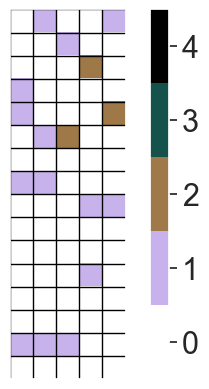

In [88]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = matplotlib.colormaps.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

def plot_colors_bar(discriminator,
                    ratio_gain_results: pd.DataFrame,
                    cells_type: dict):
    colors_data = None
    count = 0
    for idx, row in ratio_gain_results.iterrows():
        colors_vec_hash = row['hash']
        colors_vec = discriminator.cism.motifs_dataset[discriminator.cism.motifs_dataset.colors_vec_hash == colors_vec_hash].iloc[0].colors_vec
        count += len(colors_vec)
        if colors_data is None:
            colors_data = np.array(colors_vec)
        else:
            colors_data = np.append(colors_data, colors_vec)

    colors_data = colors_data.reshape(ratio_gain_results.shape[0], len(cells_type))
    colors_data = colors_data.transpose()
    print(colors_data.shape)
    number_of_colors = 5
    plt.grid(visible=True, color='black', linestyle='-', linewidth=1)
    plt.imshow(colors_data, cmap=discrete_cmap(number_of_colors, 'cubehelix_r'), vmin=0, vmax=number_of_colors)
    plt.colorbar(ticks=range(number_of_colors))
    plt.clim(-0.5, number_of_colors - 0.5)
    plt.xticks(np.arange(-.5, ratio_gain_results.shape[0]-1, 1), labels=[])
    plt.yticks(ticks=np.arange(-.5, len(cells_type)-1, 1), labels=[])
    plt.show()

plot_colors_bar(discriminator_4_nodes, ratio_gain_results, cells_type)

## 5 Nodes
## Within-motif spatial organization contributes to disease state prediction

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.


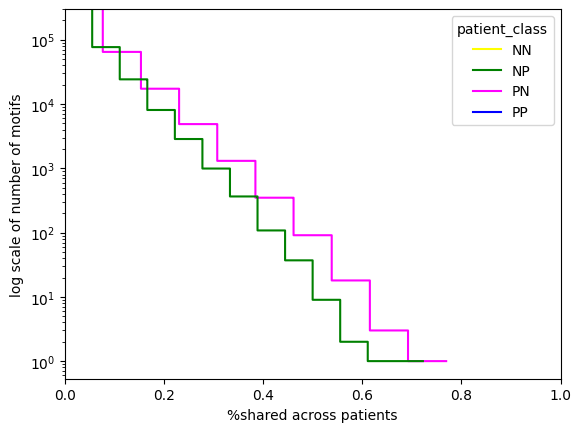

In [11]:
from cism.cism import DiscriminativeFeatureKey

discover_result = discriminator.discover(extract_by=DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES, classes=target_classes)

discover_result.plot_number_of_motifs_versus_shared_percentage(class_to_color=class_to_color)

In [13]:
shared_percentage_th = 0.4

## Permutation of Patients Classes (pipeline)

In [10]:
benchmark_results = None

In [ ]:
from cism.benchmark import DiscriminatorBenchmark
from cism.cism import DiscriminativeFeatureKey

for th in [0.4]:
    discriminator_benchmark = DiscriminatorBenchmark(
                                extract_by=DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES,
                                shared_percentage=th,
                                trials=list(range(30, 100)))

    # run permutation test
    benchmark_results = discriminator_benchmark.run(discriminator=discriminator,
                                                    labels=target_classes,
                                                    rand_patient_class=True,
                                                    rand_motifs=False,
                                                    benchmark_results=benchmark_results,
                                                    max_class_features=30,
                                                    n_jobs=1)

In [20]:
benchmark_results.to_csv(results_dir +'/' + f'rand_patient_class_pipeline_{target_classes_str}_{"0_40"}_{motif_size}_benchmark.csv')

In [14]:
from cism.cism import DiscriminativeFeatureKey, HardDiscriminativeFC

featureConf = HardDiscriminativeFC(extract_by=DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES,
                                   use_cells_type_composition=False,
                                   use_motifs=True,
                                   shared_percentage=shared_percentage_th,
                                   max_class_features=30,
                                   labels=target_classes)

motif_space_features = discriminator.get_features(feature_conf=featureConf,
                                                  exclude_patients=[],
                                                  n_jobs=1)

  0%|          | 0/31 [00:00<?, ?it/s]

In [11]:
optimal_result = discriminator.analyze_motifs(feature_conf=featureConf,
                                              exclude_patients=[],
                                              n_jobs=1)
optimal_result.get_roc_auc_score()

  0%|          | 0/31 [00:00<?, ?it/s]

0.8183760683760684

In [15]:
all_motif_features = []
for idx, row in motif_space_features.iterrows():
    all_motif_features += row['features']
all_motif_features = list(set(all_motif_features))

motif_to_cells_identity_hash = {}
for motif_id in all_motif_features:
    motif_to_cells_identity_hash[motif_id] = discriminator.cism.motifs_dataset[discriminator.cism.motifs_dataset.ID == motif_id].colors_vec_hash.iloc[0]

cell_identity_to_motif_hash = {}
for k, v in motif_to_cells_identity_hash.items():
    cell_identity_to_motif_hash[v] = cell_identity_to_motif_hash.get(v, []) + [k]

print(f"number of motifs: {len(motif_to_cells_identity_hash)}, "
      f"number of hashes: {len(cell_identity_to_motif_hash)}")

motif_to_cells_identity_hash

number of motifs: 210, number of hashes: 180


{8997153588524: 9171754553263383489,
 8859513308460: 8973669647102522552,
 114515876496684: 2998014844291062094,
 159712950913420: 9044490175703058829,
 18778789561644: 5471834280255797555,
 11005940834764: 1393154607626984584,
 124538356911596: -7439074501748739186,
 27490215316972: 3173963366501393836,
 168373625570796: -7106389048966495175,
 6761526796748: 5534609439542567147,
 81443606012364: -1333694447885158576,
 195010180304364: -1872739405361094478,
 6623919841740: -614731617902899596,
 6761661014476: 6597181975851903639,
 15422211531212: -4023549857010371685,
 93531717016012: 126039455234918397,
 159609871698220: -7576324446964418538,
 23089841867052: 123805629173401879,
 18847685151020: 8147245713023137630,
 2264557236716: -4068665342615801581,
 195010198130060: 2399008855724908344,
 25460957734348: 2976765801513590776,
 13253703340524: 8208679383083720076,
 156416642344396: 2541762929204235935,
 161818429744588: -7218900647608032808,
 187202896455116: -483653168620614135,
 1

In [17]:
target_classes[0]

'NP'

In [16]:
group_a_motifs = []
group_b_motifs = []

relevant_patients = discriminator.get_patients_class(target_classes)
for motif_id in all_motif_features:
    patients_ids = discriminator.cism.motifs_dataset[
        (discriminator.cism.motifs_dataset.ID == motif_id) &
        (discriminator.cism.motifs_dataset['Patient_uId'].isin(relevant_patients.index))]['Patient_uId'].unique()
    groups_ids = map(lambda x: relevant_patients.loc[x]['patient_class'], patients_ids)
    counter = Counter(groups_ids)
    if max(counter, key=counter.get) == target_classes[0]:
        group_a_motifs.append(motif_id)
    else:
        group_b_motifs.append(motif_id)

In [17]:
print(f'group a: {len(group_a_motifs)}')
print(f'group b: {len(group_b_motifs)}')

group a: 90
group b: 120


In [18]:
discriminator.cism.motifs_dataset['Total'] = discriminator.cism.motifs_dataset['Count']/discriminator.cism.motifs_dataset['Freq']

new_freq_table = discriminator.cism.motifs_dataset[
        (discriminator.cism.motifs_dataset.ID.isin(all_motif_features)) &
        (discriminator.cism.motifs_dataset['Patient_uId'].isin(relevant_patients.index))].groupby(['Patient', 'ID'], observed=True)[['Count', 'Total']].sum().reset_index()

new_freq_table['Freq'] = new_freq_table['Count']/new_freq_table['Total']
motif_mean_count = new_freq_table.groupby('ID')['Freq'].mean()

In [19]:
import pandas as pd
import networkx as nx
import os
import numpy as np

def create_weight_matrix_from_motifs(discriminator,
                                     cells_type: dict,
                                     cell_identity_to_motif_hash: dict,
                                     motifs_ids: list,
                                     motifs_weight: pd.DataFrame) -> pd.DataFrame:
    pairwise_cell_types_count_matrix = pd.DataFrame(index=cells_type.values(),
                                                    columns=cells_type.values(),
                                                    dtype=float).fillna(0)

    for hash_id in list(cell_identity_to_motif_hash.keys()):
        motifs = cell_identity_to_motif_hash[hash_id]
        for motif_id in motifs:
            if motif_id not in motifs_ids:
                continue
            print(f'motif_id: {motif_id}, hash_id: {hash_id}')
            target_motif = discriminator.cism.motifs_dataset[discriminator.cism.motifs_dataset.ID == motif_id].iloc[0].motif
            from cism.helpers import string_base64_pickle
            target_motif = string_base64_pickle(target_motif)
            for edge in nx.Graph(target_motif).edges():
                left_node = target_motif.nodes[edge[0]]['type']
                right_node = target_motif.nodes[edge[1]]['type']
                pairwise_cell_types_count_matrix.loc[cells_type[int(left_node)], cells_type[int(right_node)]] += motifs_weight.loc[motif_id]

    return pairwise_cell_types_count_matrix/np.matrix(pairwise_cell_types_count_matrix).sum()

motif_id: 27490215316972, hash_id: 3173963366501393836
motif_id: 6623919841740, hash_id: -614731617902899596
motif_id: 2230164107724, hash_id: -614731617902899596
motif_id: 6761661014476, hash_id: 6597181975851903639
motif_id: 15422211531212, hash_id: -4023549857010371685
motif_id: 18847685151020, hash_id: 8147245713023137630
motif_id: 2264557236716, hash_id: -4068665342615801581
motif_id: 13253703340524, hash_id: 8208679383083720076
motif_id: 58347455189484, hash_id: -1618842765494105014
motif_id: 27494553424364, hash_id: -3704244002730910530
motif_id: 27490099071436, hash_id: -832654526011799881
motif_id: 2217437768140, hash_id: -832654526011799881
motif_id: 4420599535084, hash_id: 3088789774869567602
motif_id: 8802822149612, hash_id: 7315425222917429025
motif_id: 20890998173164, hash_id: 7315425222917429025
motif_id: 93634839220524, hash_id: -8889212836152582278
motif_id: 98043670335788, hash_id: -6215516474476066241
motif_id: 8855216215436, hash_id: 5814642950009379371
motif_id: 20

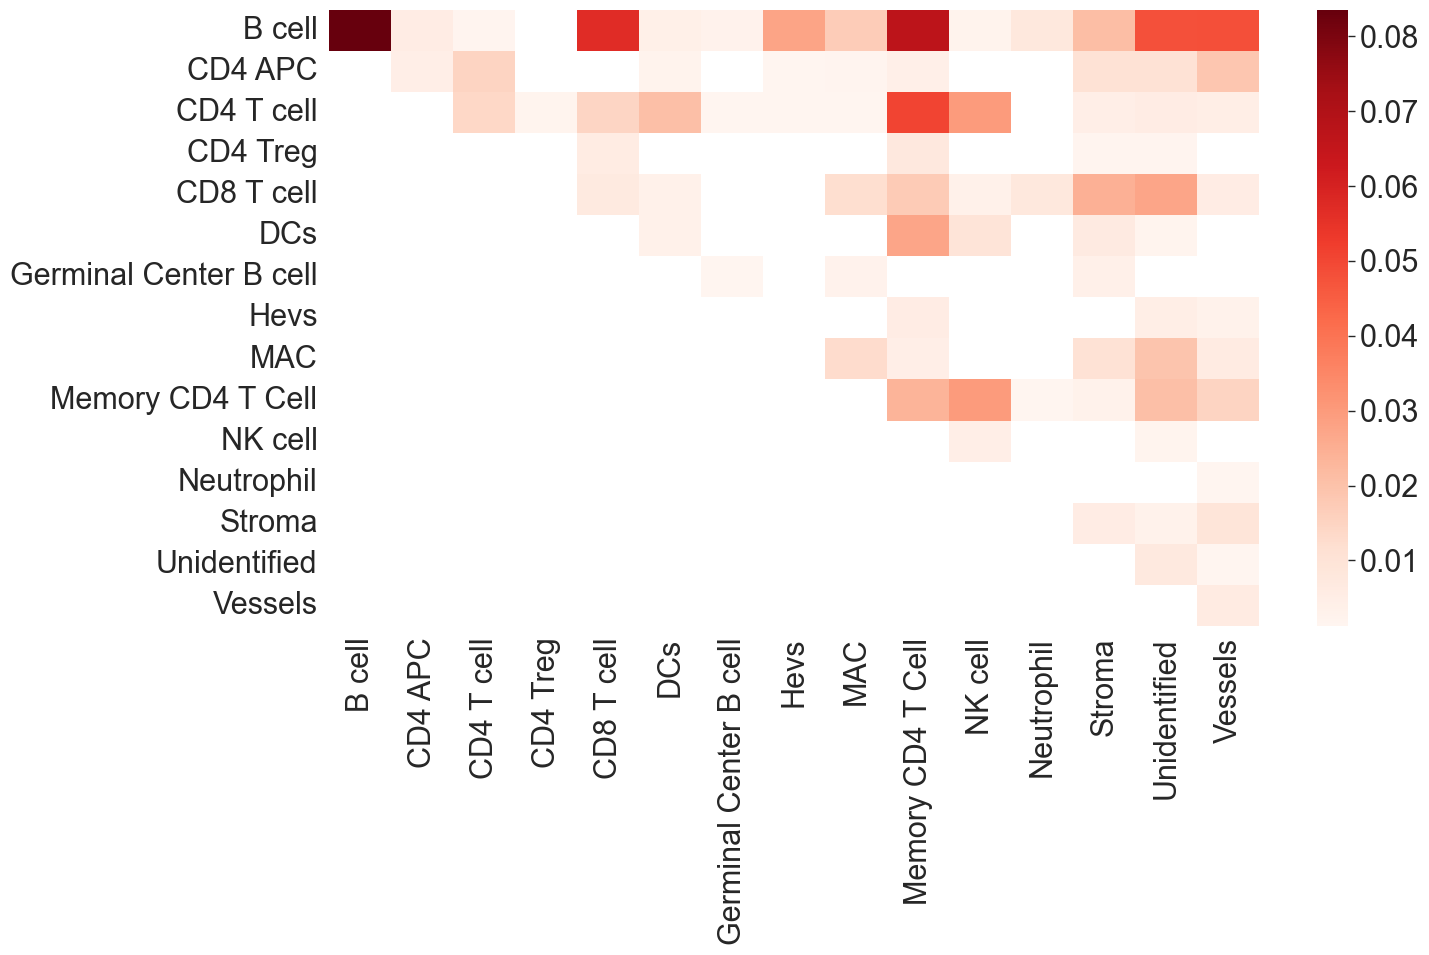

In [20]:
import seaborn as sns
from matplotlib import pyplot as plt
from cism import helpers

plt.figure(figsize=(15,8))

sns.set(font_scale=2)
sns.set_style("white")
sns.set_context("paper", font_scale=2.5)

df = create_weight_matrix_from_motifs(discriminator=discriminator,
                                      cells_type=cells_type,
                                      cell_identity_to_motif_hash=cell_identity_to_motif_hash,
                                      motifs_ids=group_a_motifs,
                                      motifs_weight=motif_mean_count)

df = df.drop(['Tumor'], axis=1)
df = df.drop(['Tumor'], axis=0)

ax = sns.heatmap(df, annot=False, mask=df==0, cmap='Reds', annot_kws={'size': 14}, fmt=".3f")

motif_id: 8997153588524, hash_id: 9171754553263383489
motif_id: 8859513308460, hash_id: 8973669647102522552
motif_id: 114515876496684, hash_id: 2998014844291062094
motif_id: 159712950913420, hash_id: 9044490175703058829
motif_id: 18778789561644, hash_id: 5471834280255797555
motif_id: 23176822441260, hash_id: 5471834280255797555
motif_id: 11005940834764, hash_id: 1393154607626984584
motif_id: 124538356911596, hash_id: -7439074501748739186
motif_id: 168373625570796, hash_id: -7106389048966495175
motif_id: 6761526796748, hash_id: 5534609439542567147
motif_id: 81443606012364, hash_id: -1333694447885158576
motif_id: 195010180304364, hash_id: -1872739405361094478
motif_id: 93531717016012, hash_id: 126039455234918397
motif_id: 97931898443212, hash_id: 126039455234918397
motif_id: 159609871698220, hash_id: -7576324446964418538
motif_id: 23089841867052, hash_id: 123805629173401879
motif_id: 195010198130060, hash_id: 2399008855724908344
motif_id: 25460957734348, hash_id: 2976765801513590776
moti

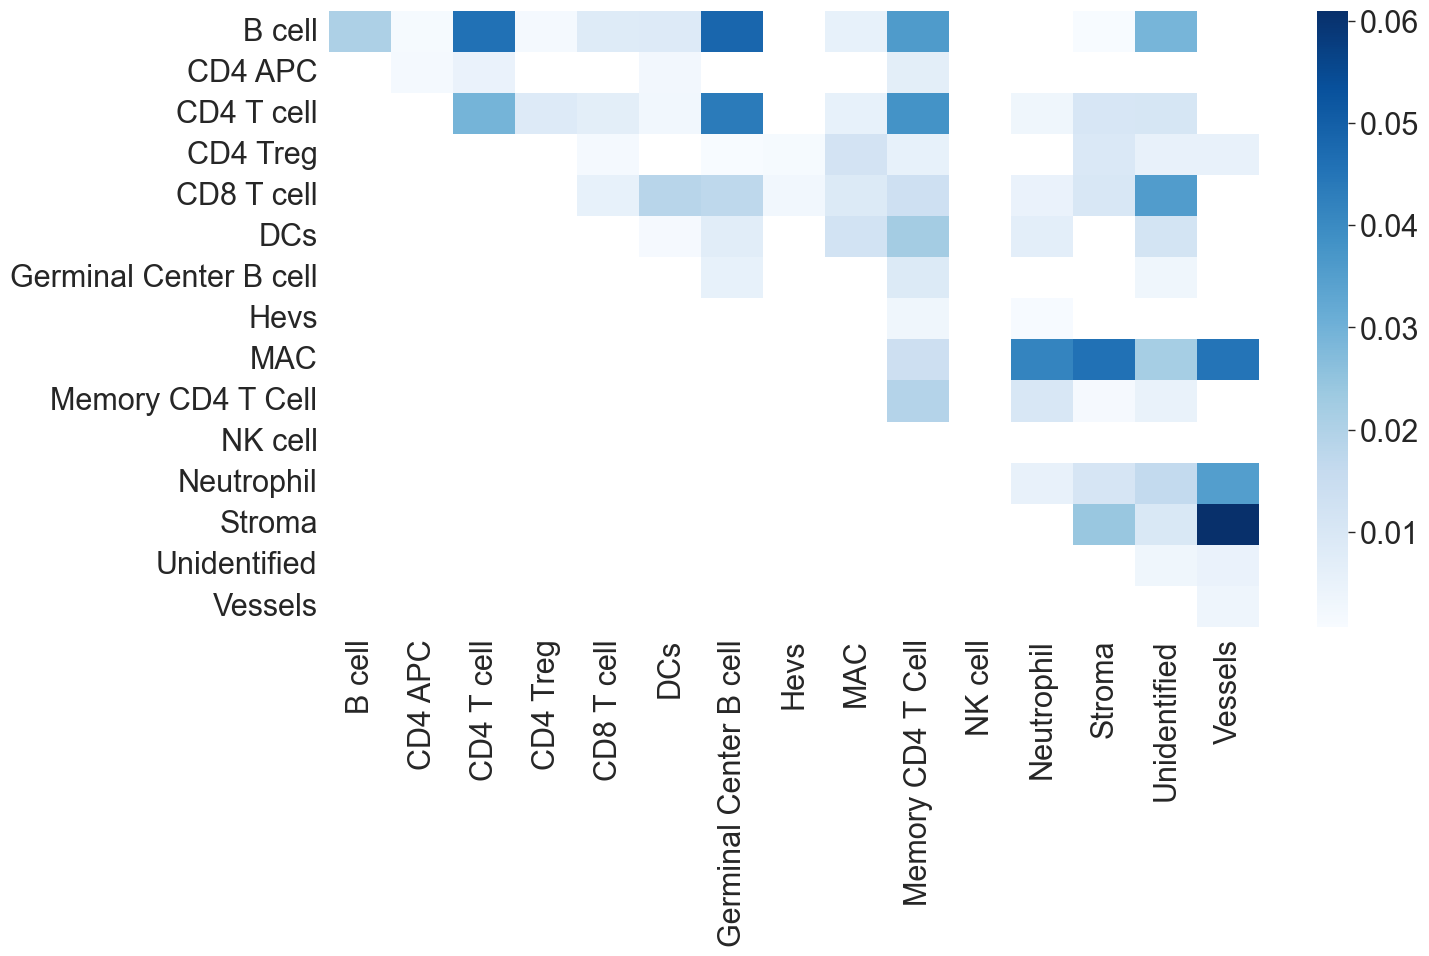

In [21]:
import seaborn as sns
from matplotlib import pyplot as plt

plt.figure(figsize=(15,8))

sns.set(font_scale=2)
sns.set_style("white")
sns.set_context("paper", font_scale=2.5)

df = create_weight_matrix_from_motifs(discriminator=discriminator,
                                      cells_type=cells_type,
                                      cell_identity_to_motif_hash=cell_identity_to_motif_hash,
                                      motifs_ids=group_b_motifs,
                                      motifs_weight=motif_mean_count)

df = df.drop(['Tumor'], axis=1)
df = df.drop(['Tumor'], axis=0)

ax = sns.heatmap(df, annot=False, mask=df==0, cmap='Blues', annot_kws={'size': 14}, fmt=".3f")

In [15]:
from typing import Union

def switch_ci(motif_space_features: pd.DataFrame,
              target_motif_ids: list,
              motif_to_cells_identity_hash: dict) -> (dict, dict):
    motifs_features_dict = dict()
    ci_features_dict = dict()

    for idx, row in motif_space_features.iterrows():
        patient_unique_id = row['test_patient_id']
        motif_ids = row['features']
        # transform to cell identity composition
        ci_features = []
        motifs_features = []
        for motif_id in motif_ids:
            if motif_id in target_motif_ids:
                motifs_features.append(motif_id)
                continue

            ci_features.append(motif_to_cells_identity_hash[motif_id])

        ci_features = list(set(ci_features))
        motifs_features_dict[patient_unique_id] = motifs_features
        ci_features_dict[patient_unique_id] = ci_features

    return motifs_features_dict, ci_features_dict

import numpy as np

switch_all_roc_auc_scores = []
for trial in range(1):
    motifs_patient_map, cell_type_composition_patient_map = \
        switch_ci(motif_space_features=motif_space_features,
                  target_motif_ids=[],
                  motif_to_cells_identity_hash=motif_to_cells_identity_hash)

    featureConf = HardDiscriminativeFC(
        extract_by=DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES,
        use_cells_type_composition=False,
        use_motifs=True,
        shared_percentage=shared_percentage_th,
        max_class_features=30,
        labels=target_classes,
        cell_type_composition_patient_map=cell_type_composition_patient_map,
        motifs_patient_map=motifs_patient_map)

    switch_all_result = discriminator.analyze_motifs(feature_conf=featureConf,
                                                     exclude_patients=[],
                                                     n_jobs=1,
                                                     random_state=np.random.RandomState(trial))

    switch_all_roc_auc_scores.append(switch_all_result.get_roc_auc_score())
    print(switch_all_result.get_roc_auc_score())

np.mean(switch_all_roc_auc_scores)

  0%|          | 0/31 [00:00<?, ?it/s]

0.6538461538461537


0.6538461538461537

In [ ]:
import numpy as np
ratio_gain_results = pd.DataFrame(columns=['hash'])

for motif_id in all_motif_features:
    hash = motif_to_cells_identity_hash[motif_id]
    # get the hash group
    motif_ids = cell_identity_to_motif_hash[hash]

    if any(ratio_gain_results.hash.isin([hash])):
        continue

    motifs_patient_map, cell_type_composition_patient_map = \
            switch_ci(motif_space_features=motif_space_features,
                      target_motif_ids=motif_ids,
                      motif_to_cells_identity_hash=motif_to_cells_identity_hash)

    roc_auc_scores = []
    for trial in [0]:
        featureConf = HardDiscriminativeFC(
            extract_by=DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES,
            use_cells_type_composition=False,
            use_motifs=True,
            shared_percentage=shared_percentage_th,
            max_class_features=30,
            labels=target_classes,
            cell_type_composition_patient_map=cell_type_composition_patient_map,
            motifs_patient_map=motifs_patient_map)

        analyze_motifs_result = discriminator.analyze_motifs(feature_conf=featureConf,
                                                             exclude_patients=[],
                                                             n_jobs=1,
                                                             random_state=0)

        roc_auc_score = analyze_motifs_result.get_roc_auc_score()
        roc_auc_scores.append(roc_auc_score)

    print(f'hash: {hash}, '
          f'roc_auc_score: {np.mean(roc_auc_scores)}, '
          f'roc_auc_ratio: {optimal_result.get_roc_auc_score()/np.mean(roc_auc_scores)}, '
          f"avg features: {analyze_motifs_result.results['cFeatures'].mean()}, "
          f"std features: {analyze_motifs_result.results['cFeatures'].std()}, "
          f"number of mapped features: {len(motif_ids)}")

    ratio_gain_results = pd.concat([ratio_gain_results,
                                    pd.DataFrame([{'hash': hash,
                                                   'roc_auc_score': np.mean(roc_auc_scores),
                                                   'roc_auc_score_std': np.std(roc_auc_scores),
                                                   'roc_auc_scores': roc_auc_scores,
                                                   'roc_auc_ratio': optimal_result.get_roc_auc_score()/np.mean(roc_auc_scores),
                                                   'avg_features': analyze_motifs_result.results['cFeatures'].mean(),
                                                   'std_features': analyze_motifs_result.results['cFeatures'].std(),
                                                   'mapped_features': len(motif_ids),
                                                   'analyze_result': analyze_motifs_result}])], ignore_index=True)
ratio_gain_results

In [ ]:
ratio_gain_results = ratio_gain_results.sort_values(by='roc_auc_score', ascending=False)
ratio_gain_results

,hash,roc_auc_score,roc_auc_score_std,roc_auc_scores,roc_auc_ratio,avg_features,std_features,mapped_features,analyze_result
15,767168531815815462,0.769231,0.0,[0.7692307692307692],1.091667,35.935484,2.205077,4.0,<cism.cism.AnalyzeMotifsResult object at 0x000...
64,2281208055654893820,0.743590,0.0,[0.7435897435897436],1.129310,35.064516,2.189908,3.0,<cism.cism.AnalyzeMotifsResult object at 0x000...
93,5471834280255797555,0.728632,0.0,[0.7286324786324786],1.152493,35.000000,2.236068,1.0,<cism.cism.AnalyzeMotifsResult object at 0x000...
96,-5275811524490822824,0.724359,0.0,[0.7243589743589745],1.159292,35.000000,2.236068,1.0,<cism.cism.AnalyzeMotifsResult object at 0x000...
111,-1345212991828422614,0.722222,0.0,[0.7222222222222221],1.162722,35.000000,2.236068,1.0,<cism.cism.AnalyzeMotifsResult object at 0x000...
...,...,...,...,...,...,...,...,...,...
161,-1683827270771291697,0.628205,0.0,[0.6282051282051282],1.336735,35.000000,2.236068,1.0,<cism.cism.AnalyzeMotifsResult object at 0x000...
99,567726125055613763,0.626068,0.0,[0.6260683760683761],1.341297,35.000000,2.236068,1.0,<cism.cism.AnalyzeMotifsResult object at 0x000...
127,-3699674701654977774,0.617521,0.0,[0.6175213675213674],1.359862,35.903226,2.413225,3.0,<cism.cism.AnalyzeMotifsResult object at 0x000...
115,7831757813731958535,0.613248,0.0,[0.6132478632478632],1.369338,35.000000,2.236068,1.0,<cism.cism.AnalyzeMotifsResult object at 0x000...


(16, 166)


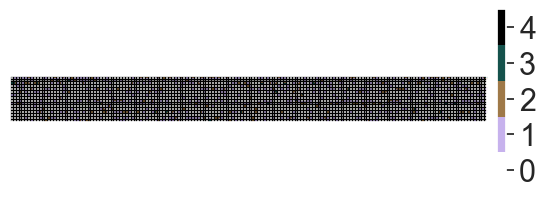

In [ ]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from cism.vis import draw

draw.plot_colors_bar(discriminator, ratio_gain_results, cells_type)

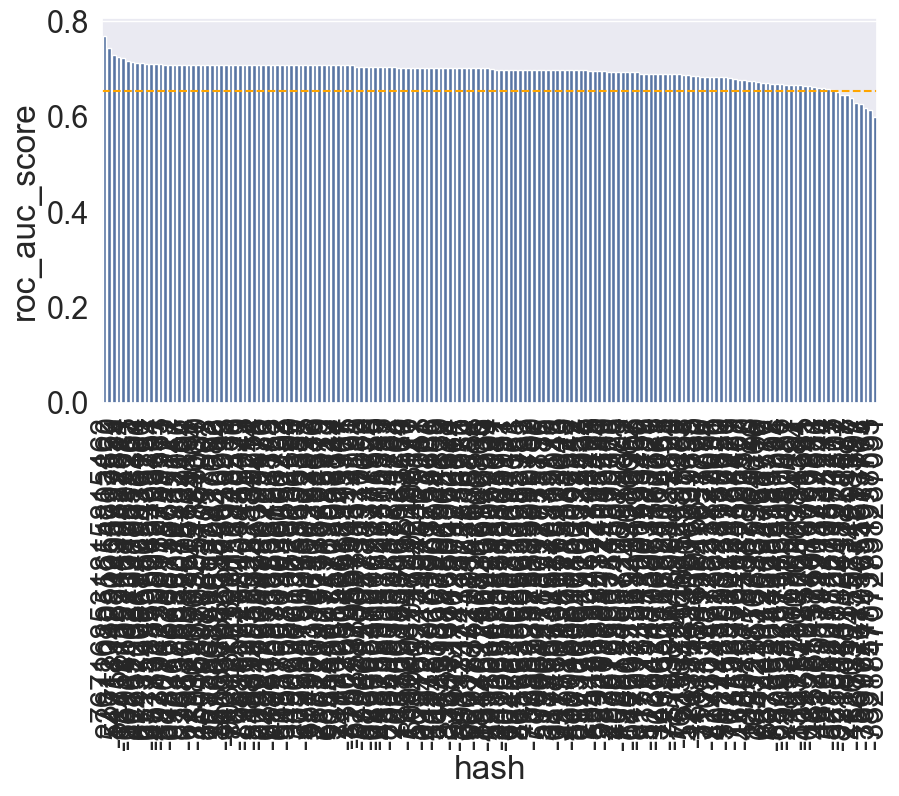

In [ ]:
import seaborn as sns
plt.figure(figsize=(10,5))
g = sns.barplot(ratio_gain_results, x='hash', y='roc_auc_score', order=ratio_gain_results['hash'])
plt.xticks(rotation=90)
g.axhline(np.mean(switch_all_roc_auc_scores), ls='--', color='orange', ms='50')

In [32]:
local_motif_size = 5

In [21]:
ratio_gain_results.to_csv(results_dir +'/' + f'ratio_gain_{target_classes_str}_{local_motif_size}_results.csv' )

In [36]:
discriminator.cism.motifs_dataset[
        (discriminator.cism.motifs_dataset.ID.isin(all_motif_features)) &
        (discriminator.cism.motifs_dataset['Patient_uId'].isin(relevant_patients.index))].groupby(['Patient', 'ID', 'colors_vec_hash'], observed=True)['Count'].sum().reset_index().to_csv(results_dir +'/' + f'{target_classes_str}_{local_motif_size}_motifs_counts_across_patients.csv')

In [12]:
discriminator.cism.motifs_dataset[(discriminator.cism.motifs_dataset.ID == 2225869055372)].groupby(['patient_class', 'Patient'], observed=True)['Count'].sum().reset_index().groupby('patient_class')['Count'].describe()

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


,count,mean,std,min,25%,50%,75%,max
patient_class,,,,,,,,
NN,7.0,45.714286,30.793475,3.0,25.50,47.0,63.00,93.0
NP,8.0,66.750000,56.024867,3.0,34.25,45.0,93.25,169.0
PN,1.0,5.000000,NaN,5.0,5.00,5.0,5.00,5.0
PP,4.0,24.500000,28.005952,1.0,7.00,16.5,34.00,64.0


In [30]:
cell_identity_to_motif_hash

{9171754553263383489: [8997153588524],
 8973669647102522552: [8859513308460],
 2998014844291062094: [114515876496684],
 9044490175703058829: [159712950913420],
 5471834280255797555: [18778789561644, 23176822441260],
 1393154607626984584: [11005940834764],
 -7439074501748739186: [124538356911596],
 3173963366501393836: [27490215316972],
 -7106389048966495175: [168373625570796],
 5534609439542567147: [6761526796748],
 -1333694447885158576: [81443606012364],
 -1872739405361094478: [195010180304364],
 -614731617902899596: [6623919841740, 2230164107724],
 6597181975851903639: [6761661014476],
 -4023549857010371685: [15422211531212],
 126039455234918397: [93531717016012, 97931898443212],
 -7576324446964418538: [159609871698220],
 123805629173401879: [23089841867052],
 8147245713023137630: [18847685151020],
 -4068665342615801581: [2264557236716],
 2399008855724908344: [195010198130060],
 2976765801513590776: [25460957734348],
 8208679383083720076: [13253703340524],
 2541762929204235935: [1564

motif_id: 27494553424364, hash_id: -3704244002730910530


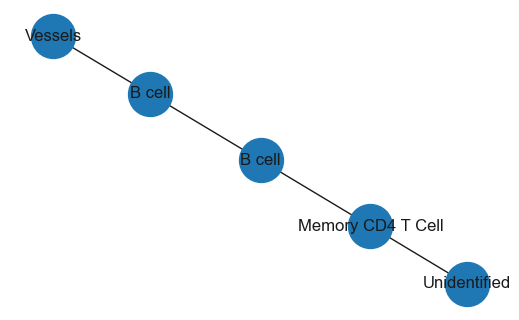

motif_id: 27567316878540, hash_id: 2281208055654893820


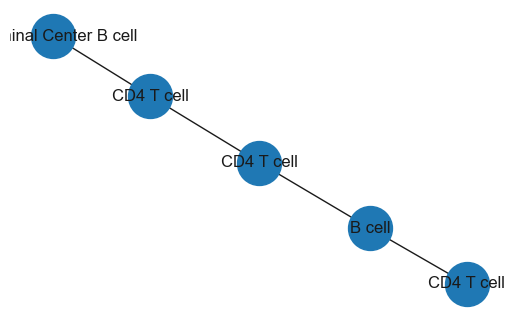

motif_id: 2225869055372, hash_id: -3528847072898287091


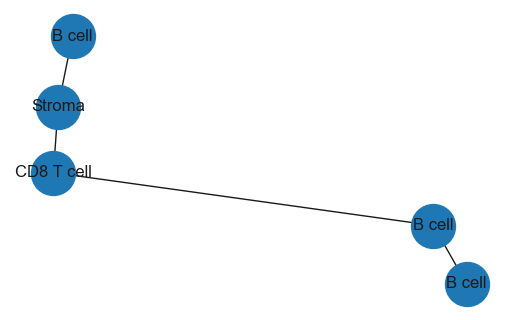

In [34]:
from cism.vis import draw

for hash_id, motifs in cell_identity_to_motif_hash.items():
    for motif_id in motifs:
        if motif_id != 27494553424364 and motif_id != 27567316878540 and motif_id != 2225869055372:
            continue
        print(f'motif_id: {motif_id}, hash_id: {hash_id}')
        target_motif = cism.motifs_dataset[cism.motifs_dataset.ID == motif_id].iloc[0].motif
        target_motif = helpers.string_base64_pickle(target_motif)
        draw.draw_motif(target_motif, cells_type=cells_type)